# Automation - Green Transition Relationship
Felix Zaussinger | 02.09.2021

## Core Analysis Goal(s)
1. check if automation scores correlate with greenness, or are higher for green/brown/neutral jobs
2.
3.

## Key Insight(s)
1.
2.
3.

In [57]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy
import scikit_posthocs as sp

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper", font_scale=1.1)
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

#### Merge automation risk and COVID-19 exposure data to own metadata

In [3]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

df_metadata.columns

Index(['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'onet_code',
       'onet_occupation', 'isco_level_1', 'isco_level_2', 'isco_level_3',
       'occupation_type', 'n_new_green_tasks', 'n_existing_green_tasks',
       'n_non_green_tasks', 'greenness_vona_2018', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training', 'skill_level_ilo',
       'new_jobs_absorbing_ilo_2030_es', 'new_jobs_net_ilo_2030_es',
       'jobs_lost_net_ilo_2030_es', 'jobs_lost_reallocated_ilo_2030_es',
       'net_change_ilo_2030_es', 'new_jobs_absorbing_ilo_2030_ce',
       'new_jobs_net_ilo_2030_ce', 'jobs_lost_net_ilo_2030_ce',
       'jobs_lost_reallocated_ilo_2030_ce', 'net_change_ilo_2030_ce',
       'is_brown', 'is_green', 'is_neutral'],
      dtype='object')

In [4]:
occ_profiles = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "processed", "ESCO_occupation_profiles.csv")
)

cols = ["concept_uri", "risk", "prevalence", "risk_category", "remote_labor_index", "physical_proximity", "exposure_score"]

In [5]:
df_merged = pd.merge(
    df_metadata,
    occ_profiles[cols],
    on="concept_uri",
    how="left"
)

df_merged["occ_type"] = df_merged[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

In [6]:
merged_cols = cols + ["occ_type", 'is_brown', 'is_green', 'is_neutral', 'greenness_vona_2018_v2',
       'total_paid_hours', 'annual_earnings', 'employment_share',
       'employment_count', 'job_zone', 'education_level',
       'related_work_experience', 'on_the_job_training']

df_merged_sel = df_merged[merged_cols]

df_merged_sel.corr()

,risk,prevalence,remote_labor_index,physical_proximity,exposure_score,is_brown,is_green,is_neutral,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training
risk,1.000000,-0.447603,0.234795,-0.117780,-0.235240,-0.138257,0.073125,0.049678,0.005821,-0.102589,0.043174,0.072657,0.072657,0.007814,0.013822,0.075063,-0.113298
prevalence,-0.447603,1.000000,-0.658416,0.109766,0.548869,0.282397,-0.118730,-0.125205,-0.068537,0.382922,-0.330013,-0.208011,-0.208011,-0.399029,-0.414113,-0.275538,0.177958
remote_labor_index,0.234795,-0.658416,1.000000,-0.294539,-0.853267,-0.366927,0.142684,0.180229,0.089281,-0.323381,0.493500,0.153483,0.153483,0.651638,0.661463,0.564568,0.029440
physical_proximity,-0.117780,0.109766,-0.294539,1.000000,0.721857,-0.020854,-0.101734,0.094734,-0.119196,-0.176303,-0.278389,0.129932,0.129931,-0.268971,-0.252423,-0.292694,-0.082296
exposure_score,-0.235240,0.548869,-0.853267,0.721857,1.000000,0.244944,-0.150862,-0.078380,-0.121855,0.143431,-0.479527,-0.042029,-0.042029,-0.600331,-0.605619,-0.542041,-0.040623
is_brown,-0.138257,0.282397,-0.366927,-0.020854,0.244944,1.000000,-0.157509,-0.644771,-0.105951,0.309086,-0.189963,-0.222982,-0.222982,-0.327262,-0.301076,-0.253189,-0.026855
is_green,0.073125,-0.118730,0.142684,-0.101734,-0.150862,-0.157509,1.000000,-0.653276,0.727873,0.156962,0.200614,0.007801,0.007802,0.152735,0.142020,0.204946,0.155735
is_neutral,0.049678,-0.125205,0.180229,0.094734,-0.078380,-0.644771,-0.653276,1.000000,-0.482169,-0.358467,-0.009640,0.182839,0.182837,0.133353,0.121525,0.035935,-0.100018
greenness_vona_2018_v2,0.005821,-0.068537,0.089281,-0.119196,-0.121855,-0.105951,0.727873,-0.482169,1.000000,0.138668,0.147234,-0.021775,-0.021774,0.145518,0.142352,0.140335,0.135397
total_paid_hours,-0.102589,0.382922,-0.323381,-0.176303,0.143431,0.309086,0.156962,-0.358467,0.138668,1.000000,0.251020,-0.355864,-0.355863,-0.184949,-0.244074,0.055965,0.388621


#### Are B/G/N occupations correlated with automation risk?
- brown occs are negatively correlated
- green and neutral occs are very weakly positively correlated

In [7]:
from scipy import stats

test = df_merged_sel[["is_brown", "is_green", "is_neutral", "risk"]].dropna()
print(stats.pointbiserialr(test.is_brown, test.risk))
print(stats.pointbiserialr(test.is_green, test.risk))
print(stats.pointbiserialr(test.is_neutral, test.risk))


PointbiserialrResult(correlation=-0.13825668385121317, pvalue=1.1390818027553507e-13)
PointbiserialrResult(correlation=0.07312499040080478, pvalue=9.122819519603425e-05)
PointbiserialrResult(correlation=0.04967764138866231, pvalue=0.007901309934273565)


#### What is the differential exposure of B/G/N to automation risk and COVID-19 measures?

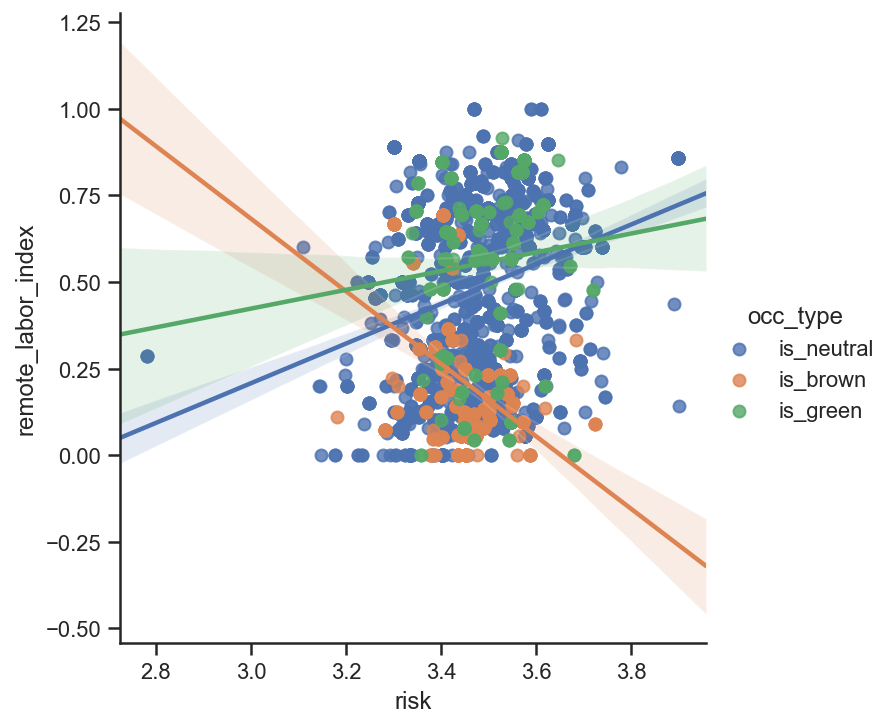

In [8]:
sns.lmplot(
    x="risk",
    y="remote_labor_index",
    hue="occ_type",
    truncate=False,
    data=df_merged_sel
)

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "rli_vs_risk.png"),
    bbox_inches="tight",
    dpi=300
)

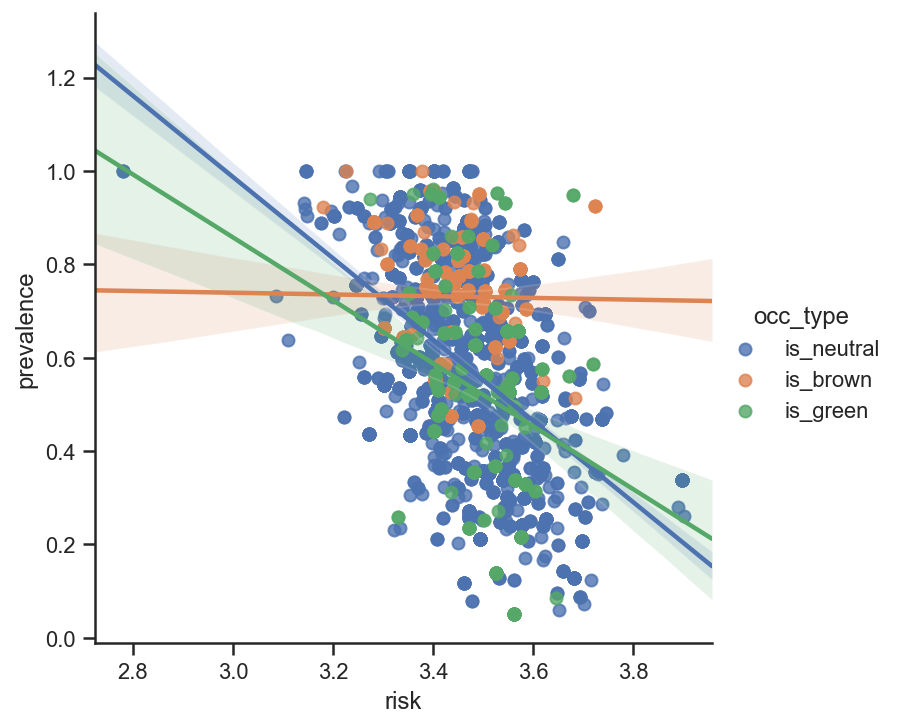

In [9]:
sns.lmplot(
    x="risk",
    y="prevalence",
    hue="occ_type",
    truncate=False,
    data=df_merged_sel
)

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "prevalence_vs_risk.png"),
    bbox_inches="tight",
    dpi=300
)

#### Does the greenness of an occupation correlate with automation risk and COVID-19 exposure measures?

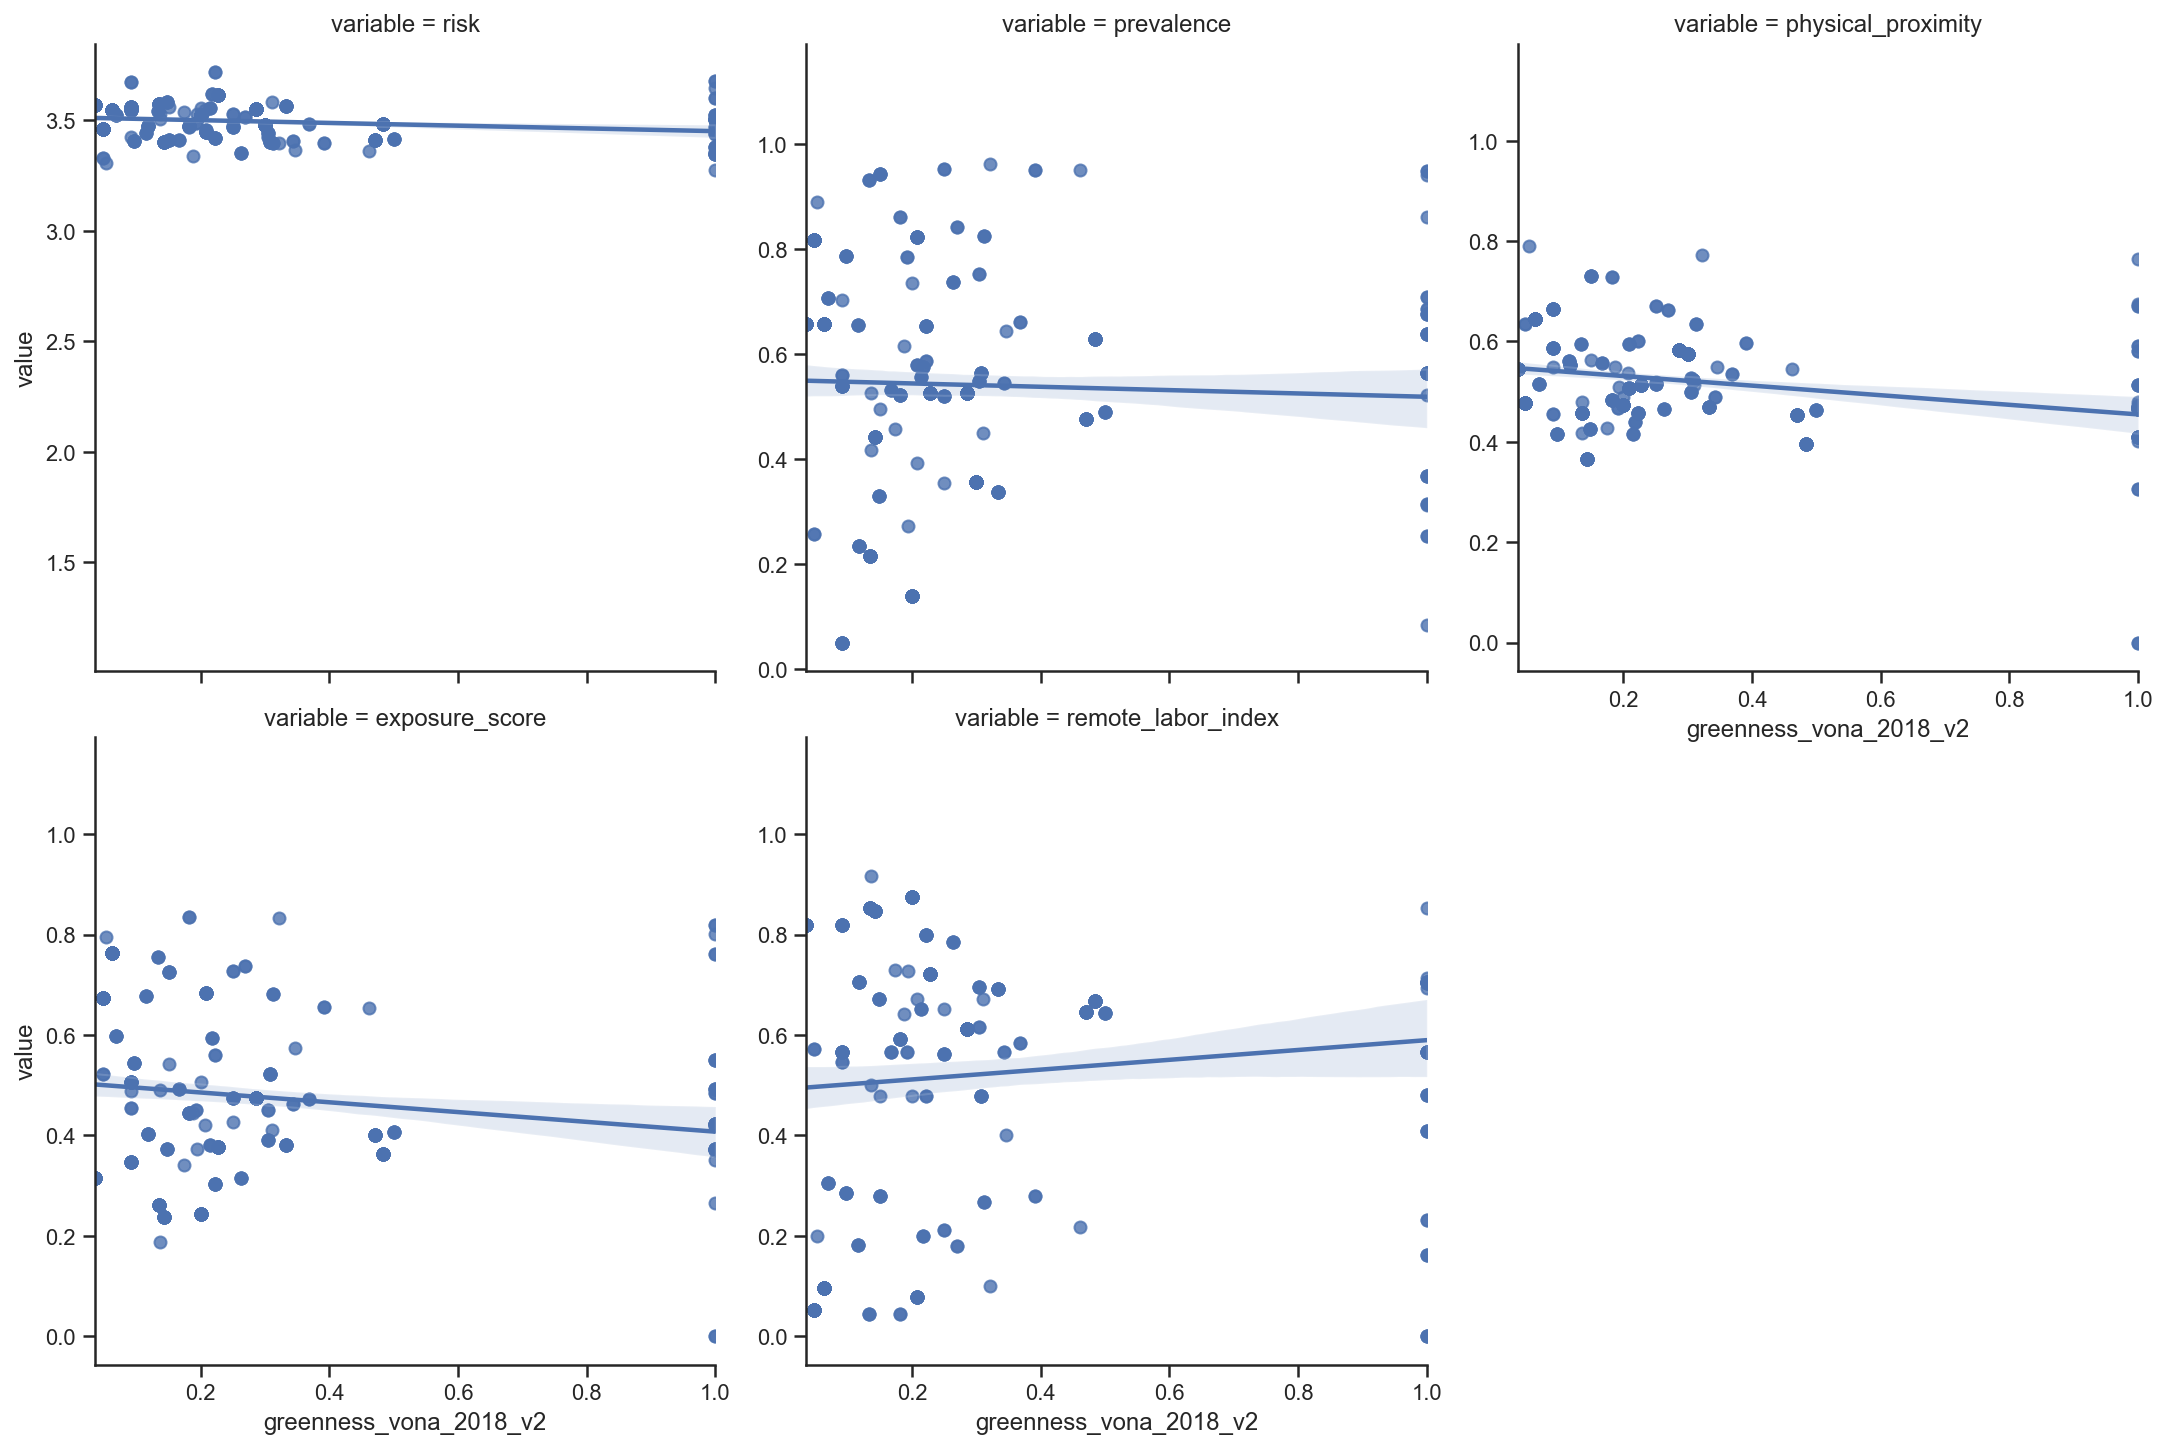

In [10]:
greenness_subset = df_merged_sel[
    ["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index", "greenness_vona_2018_v2"]
].query("greenness_vona_2018_v2 > 0")

greenness_subset_long = greenness_subset.melt(
    id_vars="greenness_vona_2018_v2",
    value_vars=["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index"]
)

greenness_subset_long = greenness_subset_long.dropna()

sns.lmplot(
    x="greenness_vona_2018_v2",
    y="value",
    col="variable",
    data=greenness_subset_long,
    sharey=False,
    #sharex=True,
    col_wrap=3,
)

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "greenness_subset_correlations.png"),
    bbox_inches="tight",
    dpi=300
)

#### How do automation risk and COVID-19 exposure measures vary between G/B/N occupations?

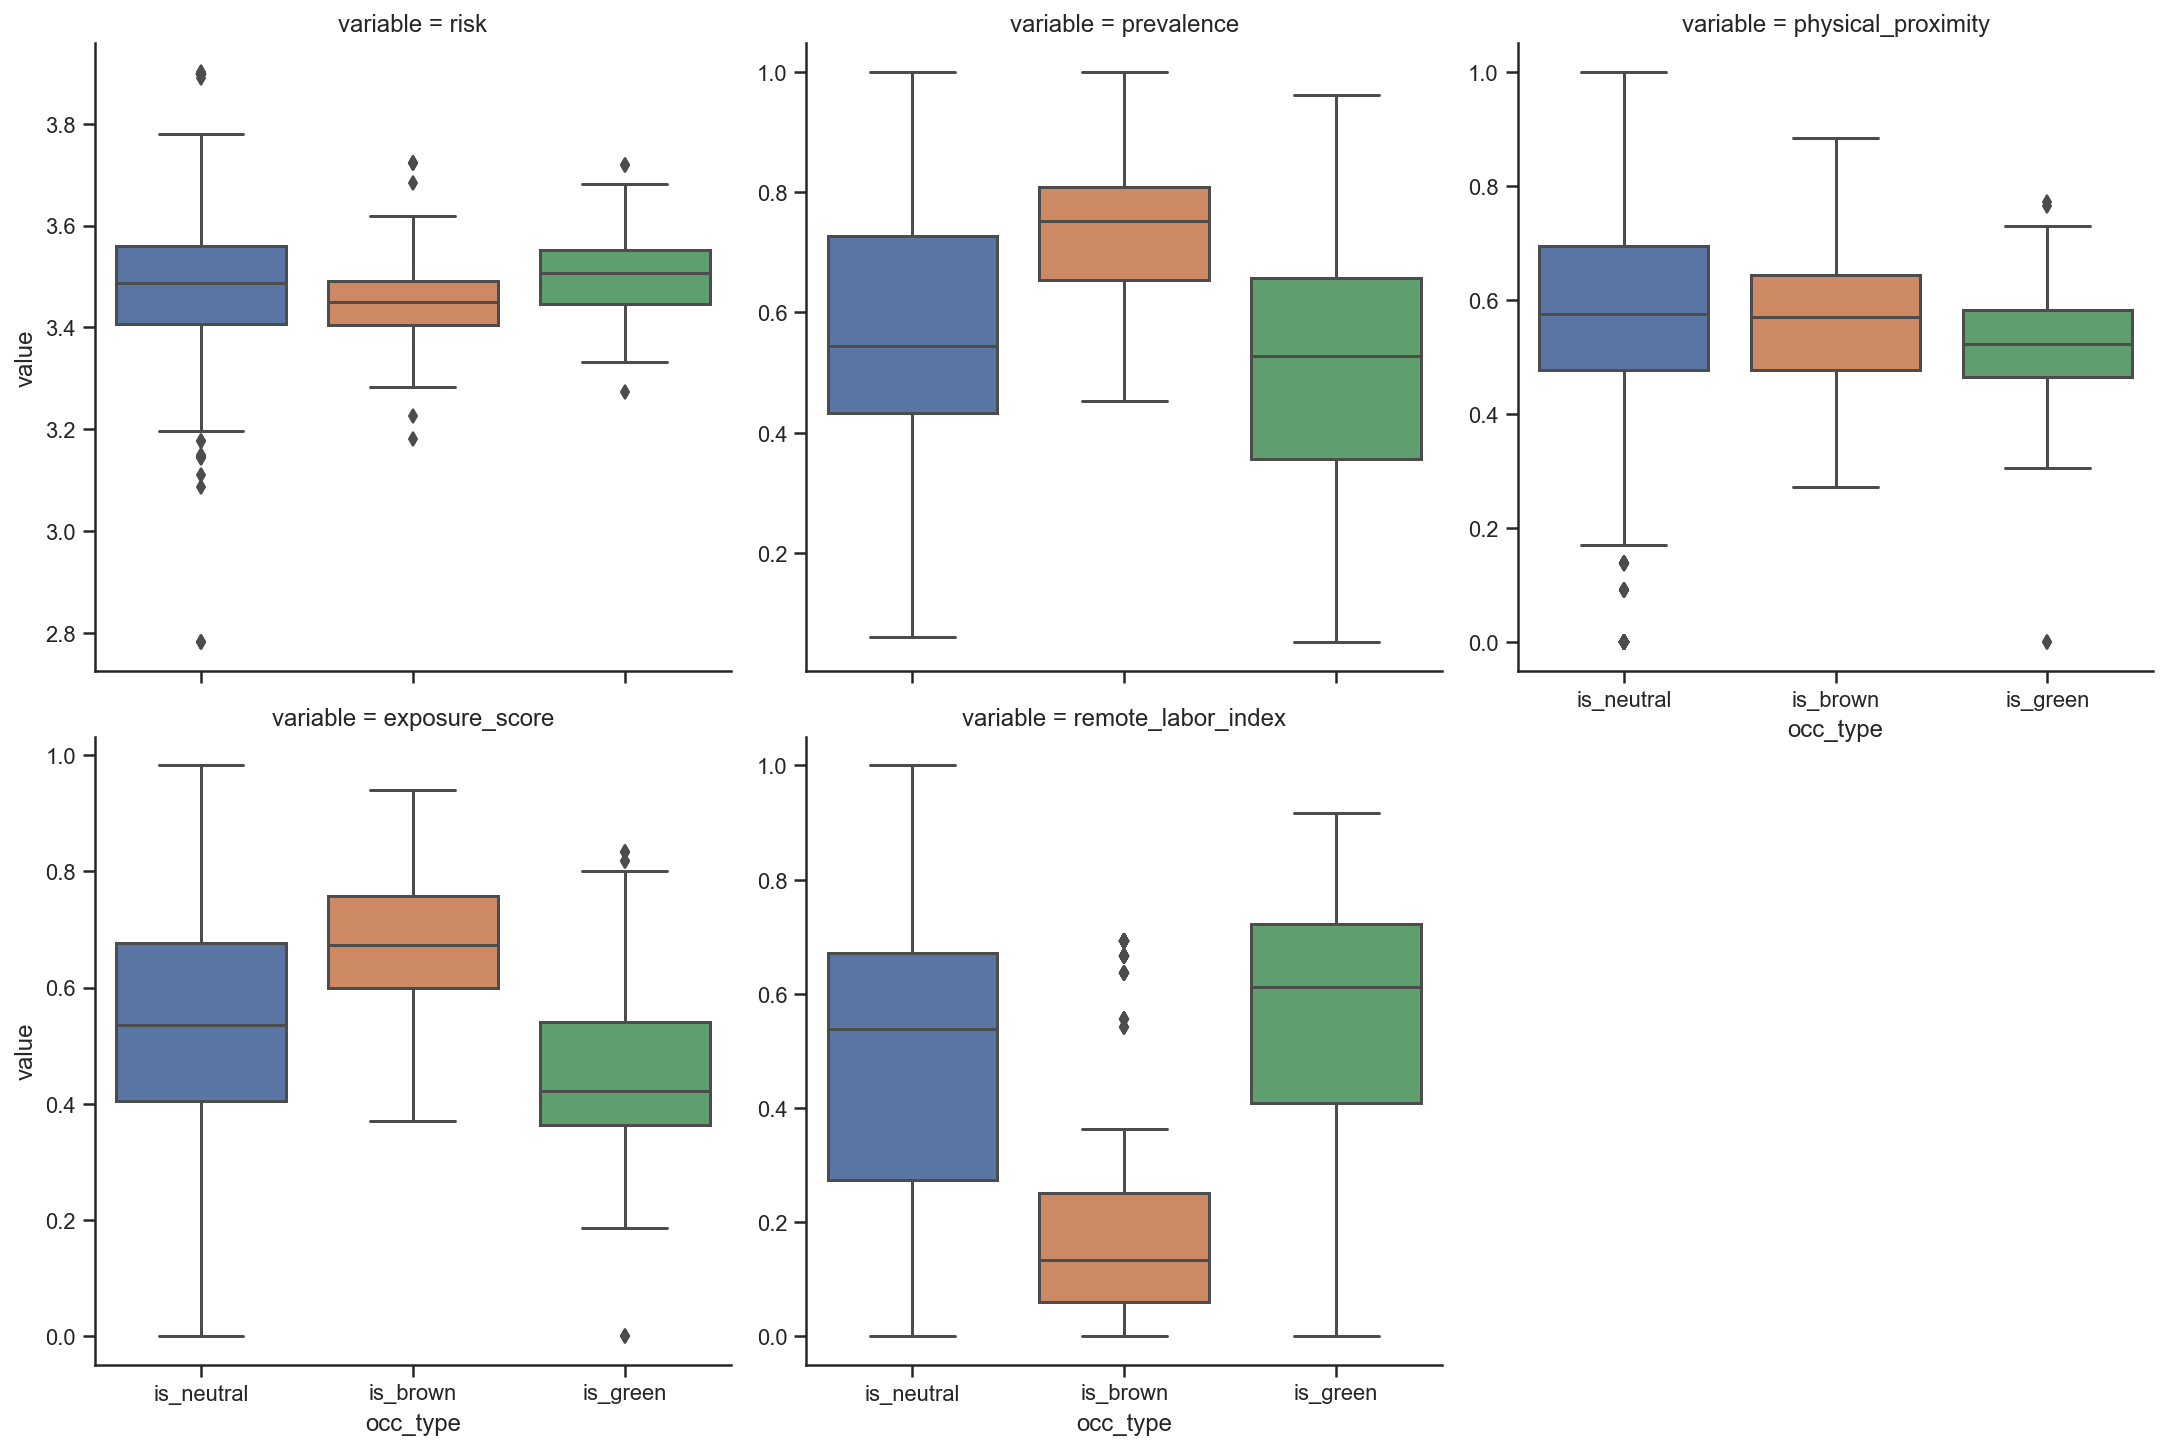

In [11]:
sns.catplot(
    x="occ_type",
    y="value",
    col="variable",
    col_wrap=3,
    kind="box",
    sharey=False,
    data=df_merged_sel.melt(
    id_vars=["occ_type"],
    value_vars=["risk", "prevalence", "physical_proximity", "exposure_score", "remote_labor_index"]
    )
)

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "gbn_characteristics.png"),
    bbox_inches="tight",
    dpi=300
)

In [12]:
replace_occ_types = {
    "is_neutral": "neutral",
    "is_brown": "brown",
    "is_green": "green"
}

#### Automation

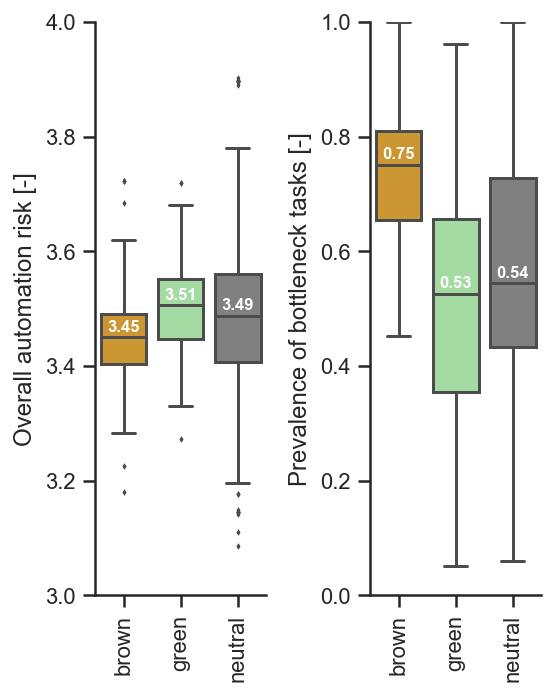

In [53]:
vars = ["risk", "prevalence"]
data = df_merged_sel.melt(
    id_vars=["occ_type"],
    value_vars=vars,
    ).replace(replace_occ_types)

c = sns.catplot(
    x="occ_type",
    y="value",
    col="variable",
    col_wrap=2,
    kind="box",
    order=["brown", "green", "neutral"],
    palette=["orange", "lightgreen", "grey"],
    saturation=0.6,
    sharey=False,
    height=5,
    aspect=0.4,
    fliersize=1,
    data=data
)

c.axes[0].set_title(None)
c.axes[1].set_title(None)

c.axes[0].set_xlabel(None)
c.axes[1].set_xlabel(None)

c.axes[0].set_ylabel("Overall automation risk [-]")
c.axes[1].set_ylabel("Prevalence of bottleneck tasks [-]")

c.axes[0].set_ylim(3, 4)
c.axes[1].set_ylim(0, 1)

c.set_xticklabels(rotation=90)

# annotate medians
medians = data.groupby(["variable", "occ_type"]).median()
vertical_offset = 0.01

for i, ax in enumerate(c.axes):
    median = medians.loc[vars[i]]
    for xtick in ax.get_xticks():
        ax.text(xtick,
                median.iloc[xtick, 0] + vertical_offset,
                "{:.2f}".format(median.iloc[xtick, 0]),
                horizontalalignment='center',
                size='x-small',
                color='w',
                weight='semibold')

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "gbn_characteristics_automation.png"),
    bbox_inches="tight",
    dpi=300
)

Differences significant?

In [55]:
data.query()

,occ_type,variable,value
0,neutral,risk,3.467411
1,brown,risk,3.307599
2,green,risk,3.547436
3,neutral,risk,3.460182
4,neutral,risk,3.624351
...,...,...,...
5837,neutral,prevalence,0.391722
5838,green,prevalence,0.686050
5839,neutral,prevalence,0.413372
5840,neutral,prevalence,0.614912


In [ ]:
scipy.stats.kruskal()

In [72]:
for var in data.variable.unique():
    test = sp.posthoc_dunn(
        data.query("variable == '{}'".format(var)),
        val_col="value",
        group_col="occ_type",
        p_adjust="bonferroni"
    )

    print(var)
    print(test)

risk
            brown     green   neutral
brown    1.00e+00  6.00e-18  2.65e-15
green    6.00e-18  1.00e+00  3.07e-03
neutral  2.65e-15  3.07e-03  1.00e+00
prevalence
            brown     green   neutral
brown    1.00e+00  1.62e-43  3.47e-50
green    1.62e-43  1.00e+00  7.95e-03
neutral  3.47e-50  7.95e-03  1.00e+00


#### COVID

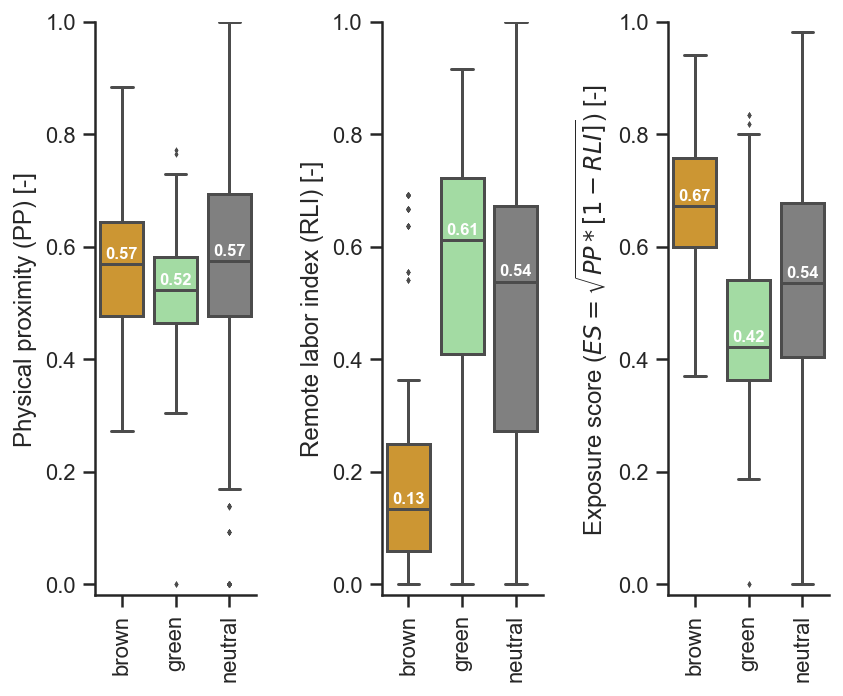

In [73]:
vars = ["physical_proximity", "remote_labor_index", "exposure_score"]

data = df_merged_sel.melt(
    id_vars=["occ_type"],
    value_vars=vars
    ).replace(replace_occ_types)

c = sns.catplot(
    x="occ_type",
    y="value",
    col="variable",
    col_wrap=3,
    kind="box",
    order=["brown", "green", "neutral"],
    palette=["orange", "lightgreen", "grey"],
    saturation=0.6,
    sharey=False,
    height=5,
    aspect=0.4,
    fliersize=1,
    data=data
)

# labels
c.axes[0].set_title(None)
c.axes[1].set_title(None)
c.axes[2].set_title(None)

c.axes[0].set_xlabel(None)
c.axes[1].set_xlabel(None)
c.axes[2].set_xlabel(None)

c.axes[0].set_ylabel("Physical proximity (PP) [-]")
c.axes[1].set_ylabel("Remote labor index (RLI) [-]")
c.axes[2].set_ylabel("Exposure score ($ES = \sqrt{PP*[1-RLI]}$) [-] ")

c.axes[0].set_ylim(-0.02, 1)
c.axes[1].set_ylim(-0.02, 1)
c.axes[2].set_ylim(-0.02, 1)

c.set_xticklabels(rotation=90)

# annotate medians
medians = data.groupby(["variable", "occ_type"]).median()
vertical_offset = 0.01

for i, ax in enumerate(c.axes):
    median = medians.loc[vars[i]]
    for xtick in ax.get_xticks():
        ax.text(xtick,
                median.iloc[xtick, 0] + vertical_offset,
                "{:.2f}".format(median.iloc[xtick, 0]),
                horizontalalignment='center',
                size='x-small',
                color='w',
                weight='semibold')

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "automation_covid", "gbn_characteristics_covid19.png"),
    bbox_inches="tight",
    dpi=300
)

Differences significant?

In [82]:
for var in data.variable.unique():
    test = sp.posthoc_dunn(
        data.query("variable == '{}'".format(var)),
        val_col="value",
        group_col="occ_type",
        p_adjust="bonferroni"
    )

    print(var)
    print(test)

physical_proximity
            brown     green   neutral
brown    1.00e+00  6.56e-04  2.07e-02
green    6.56e-04  1.00e+00  1.32e-13
neutral  2.07e-02  1.32e-13  1.00e+00
remote_labor_index
            brown     green   neutral
brown    1.00e+00  8.87e-57  2.01e-61
green    8.87e-57  1.00e+00  3.69e-05
neutral  2.01e-61  3.69e-05  1.00e+00
exposure_score
            brown     green   neutral
brown    1.00e+00  2.86e-44  1.61e-30
green    2.86e-44  1.00e+00  4.03e-11
neutral  1.61e-30  4.03e-11  1.00e+00


,occ_type,variable,value
0,neutral,physical_proximity,0.58
3,neutral,physical_proximity,0.54
4,neutral,physical_proximity,0.36
5,neutral,physical_proximity,0.65
7,neutral,physical_proximity,0.88
...,...,...,...
2915,neutral,physical_proximity,0.70
2916,neutral,physical_proximity,0.36
2918,neutral,physical_proximity,0.68
2919,neutral,physical_proximity,0.45


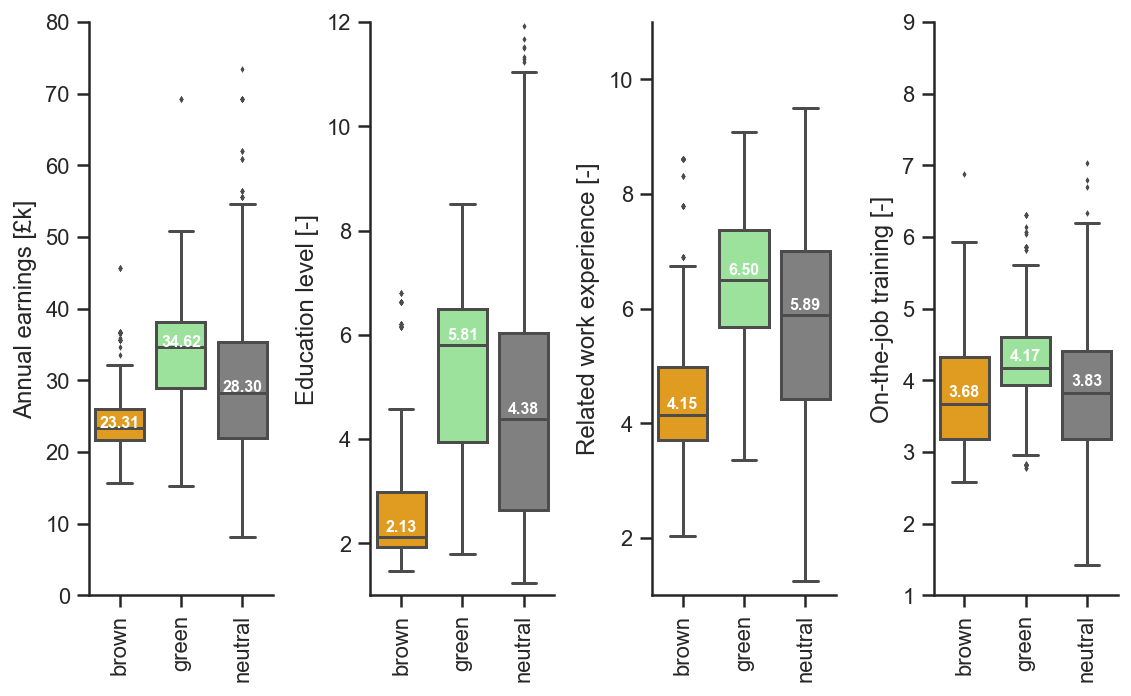

In [110]:
# general characteristics
vars = ["annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
data = df_merged_sel.melt(
    id_vars=["occ_type"],
    value_vars=vars
    ).replace(replace_occ_types)

# go from GBP to 1000 GPB for plotting
frac = 1000
data.loc[data.variable == "annual_earnings", "value"] /= frac

c = sns.catplot(
    y="value",
    x="occ_type",
    col="variable",
    col_wrap=4,
    order=["brown", "green", "neutral"],
    palette=["orange", "lightgreen", "grey"],
    fliersize=1,
    kind="box",
    sharey=False,
    data=data,
    height=5,
    aspect=0.4,
)

# labels
c.axes[0].set_ylabel("Annual earnings [£k]")
c.axes[1].set_ylabel("Education level [-]")
c.axes[2].set_ylabel("Related work experience [-]")
c.axes[3].set_ylabel("On-the-job training [-]")

c.axes[0].set_xlabel(None)
c.axes[1].set_xlabel(None)
c.axes[2].set_xlabel(None)
c.axes[3].set_xlabel(None)

c.axes[0].set_title(None)
c.axes[1].set_title(None)
c.axes[2].set_title(None)
c.axes[3].set_title(None)

c.axes[0].set_ylim(0, 80000 / frac)
c.axes[1].set_ylim(1, 12)
c.axes[2].set_ylim(1, 11)
c.axes[3].set_ylim(1, 9)

c.set_xticklabels(rotation=90)

# annotate medians
medians = data.groupby(["variable", "occ_type"]).median()
vertical_offset = 0.1

for i, ax in enumerate(c.axes):
    median = medians.loc[vars[i]]
    for xtick in ax.get_xticks():
        ax.text(xtick,
                median.iloc[xtick, 0] + vertical_offset,
                "{:.2f}".format(median.iloc[xtick, 0]),
                horizontalalignment='center',
                size=8,
                color='w',
                weight='semibold')

plt.tight_layout()
plt.savefig(
    os.path.join(figure_dir, "automation_covid", "educ_pay_by_occupation_type_v2.png"),
    bbox_inches="tight",
    dpi=300
)

Differences significant?

In [112]:
for var in data.variable.unique():
    test = sp.posthoc_dunn(
        data.query("variable == '{}'".format(var)),
        val_col="value",
        group_col="occ_type",
        p_adjust="bonferroni"
    )

    print(var)
    print(test)

annual_earnings
            brown     green   neutral
brown    1.00e+00  4.24e-55  4.82e-23
green    4.24e-55  1.00e+00  8.03e-25
neutral  4.82e-23  8.03e-25  1.00e+00
education_level
            brown     green   neutral
brown    1.00e+00  1.11e-76  1.50e-62
green    1.11e-76  1.00e+00  9.26e-13
neutral  1.50e-62  9.26e-13  1.00e+00
related_work_experience
            brown     green   neutral
brown    1.00e+00  4.61e-58  8.19e-34
green    4.61e-58  1.00e+00  1.28e-17
neutral  8.19e-34  1.28e-17  1.00e+00
on_the_job_training
            brown     green   neutral
brown    1.00e+00  2.16e-11  1.00e+00
green    2.16e-11  1.00e+00  9.62e-17
neutral  1.00e+00  9.62e-17  1.00e+00


#### Occupation examples for automation risk & prevalence

In [16]:
n = 5
cols = ["preferred_label", "occ_type", "risk", "prevalence", "exposure_score"]

result = pd.concat(
    [
        pd.DataFrame(df_merged[cols].query("occ_type == 'is_green'").groupby(["occ_type", "risk", "prevalence", "exposure_score"])['preferred_label'].apply(lambda x: ', '.join(x))).reset_index().nlargest(n, "risk").reset_index(drop=True),
        pd.DataFrame(df_merged[cols].query("occ_type == 'is_brown'").groupby(["occ_type", "risk", "prevalence", "exposure_score"])['preferred_label'].apply(lambda x: ', '.join(x))).reset_index().nlargest(n, "risk").reset_index(drop=True),
        pd.DataFrame(df_merged[cols].query("occ_type == 'is_neutral'").groupby(["occ_type", "risk", "prevalence", "exposure_score"])['preferred_label'].apply(lambda x: ', '.join(x))).reset_index().nlargest(n, "risk").reset_index(drop=True)
    ]
)

result = result.replace(replace_occ_types)
result = result.set_index(["occ_type", result.index])
colnames = {"preferred_label": "Occupation", "risk": "Risk", "prevalence": "Prevalence", "exposure_score": "Exposure score"}
result = result.rename(columns=colnames)


result.to_csv(
    os.path.join(data_processed, "automation_examples.csv"),
    float_format="%.2f"
)

In [17]:
result

Risk  Prevalence  Exposure score  \
occ_type                                           
green    0  3.719158    0.586979        0.559503   
         1  3.680699    0.947499        0.818535   
         2  3.671908    0.560676        0.454773   
         3  3.646611    0.085097        0.264575   
         4  3.618202    0.574766        0.593296   
brown    0  3.723577    0.923890        0.868646   
         1  3.684242    0.514507        0.653197   
         2  3.619482    0.550539        0.633712   
         3  3.586522    0.704947        0.567891   
         4  3.573213    0.789110        0.757973   
neutral  0  3.901837    0.261623        0.747854   
         1  3.897832    0.337838        0.265922   
         2  3.890284    0.279313        0.636396   
         3  3.779668    0.392221        0.336031   
         4  3.745089    0.481901        0.591608   

                                                   Occupation  
occ_type                                                       
green    0  non-vessel operating common carrier, internati...  
         1  asbestos abatement worker, decontamination worker  
         2        vessel operations coordinator, ship planner  
         3                      solar energy sales consultant  
         4  soil surveying technician, geotechnician, geol...  
brown    0  fiberglass laminator, fibreglass machine opera...  
         1                                casting mould maker  
         2                                       tool grinder  
         3  tumbling machine operator, blanching operator,...  
         4  spinning textile technician, twisting machine ...  
neutral  0                                    hotel concierge  
         1  aerospace engineering drafter, electromechanic...  
         2                          funeral services director  
         3                                   investment clerk  
         4                 precious stone cutter, gemmologist